This is a small example showing how to use [fastai](https://www.fast.ai) to train on the original [MNIST](http://yann.lecun.com/exdb/mnist) dataset. This dataset contains 70,000 handwritten digits from 0 to 9. 60,000 for training and 10,1000 for testing. Each digit is a tiny grayscale 28x28 image.

It took me a while to piece together everything using information from the fastai book, tutorials, and forum. The MNIST data is stored as a binary blob, where as all the vision examples in fastai expects a folder of images. So it required writing some custom code to use their API. I hope this example will save some people some time!

For training I use a pre-trained resnet model and ran fastai's fine tuning function. 

This Jupyter notebook can be downloaded here https://github.com/nghiaho12/fastai_projects/blob/main/mnist.ipynb 

# Table of Contents
1. [Installation](#installation)
2. [Load the MNIST data](#load)
3. [Visualize some the data](#viz)
4. [Custom Transform class](#transform)
5. [Setup Dataloaders](#dataloaders)
6. [Train the model](#train)
7. [Evaluate the model on the test set](#test_eval)
8. [Visualize misclassification](#viz_miss)
9. [Conclusion](#conclusion)

# 1. Installation <a name="installation"></a>
You can skip this if you already have these packages.

In [ ]:
import sys

!{sys.executable} -m pip install fastai
!{sys.executable} -m pip install gzip

# 2. Load the MNIST data <a name="load"></a>
This will download the MNIST data if you don't have it already.

In [1]:
from fastai.vision.all import *
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
import sys
import gzip
import os

plt.style.use('dark_background')

# http://yann.lecun.com/exdb/mnist/
def read_mnist_image(file):
    with gzip.open(file, 'r') as f:
        f.read(4) # magic number
        num_images = int.from_bytes(f.read(4), byteorder='big')
        image_height = int.from_bytes(f.read(4), byteorder='big')
        image_width = int.from_bytes(f.read(4), byteorder='big')

        buf = f.read(image_width * image_height * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, image_height, image_width)
        data = data.astype(dtype=np.float32) / 255.0 # normalize to [0,1]
        
        return data
    
def read_mnist_label(file):
    with gzip.open(file, 'r') as f:
        f.read(4) # magic number
        num_labels = int.from_bytes(f.read(4), byteorder='big')
        buf = f.read(num_labels)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.int32)

        return data
    
# download dataset if it doesn't exist    
files = ['train-images-idx3-ubyte.gz', 
         'train-labels-idx1-ubyte.gz', 
         't10k-images-idx3-ubyte.gz', 
         't10k-labels-idx1-ubyte.gz']

for f in files:
    if not os.path.exists(f):        
        url = 'http://yann.lecun.com/exdb/mnist/' + f
        print(url)
        download_url(url, f)
        
train_image = read_mnist_image('train-images-idx3-ubyte.gz')
train_label = read_mnist_label('train-labels-idx1-ubyte.gz')
test_image = read_mnist_image('t10k-images-idx3-ubyte.gz')
test_label = read_mnist_label('t10k-labels-idx1-ubyte.gz')

print("")
print("train_image:", train_image.shape)
print("train_label:", train_label.shape)
print("test_image:", test_image.shape)
print("test_label:", test_label.shape)

http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz



http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz



http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz



http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz




train_image: (60000, 28, 28)
train_label: (60000,)
test_image: (10000, 28, 28)
test_label: (10000,)


# 3. Visualize some of the data <a name="viz">
This is a sanity check to make sure we loaded the images correctly. They are actually grayscale images but matplotlib automatically applies a colormap to images stored as floats.

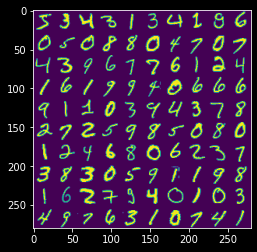

In [2]:
nrows = 10
ncols = 10

_, h, w = train_image.shape
canvas = Image.new('F', (ncols*w, nrows*h))

idx = 0
for i in range(nrows):
    for j in range(ncols):
        image = Image.fromarray(train_image[idx])
        canvas.paste(image, (i*h, j*w))
        idx += 1
        
imshow(np.asarray(canvas));

# 4. Custom Transform class <a name="transform">
Based on information from https://docs.fast.ai/tutorial.siamese.html and some post in the fastai forum. This class allows passing in a numpy array as the data. I also implemented show_batch in case I needed to visualize the batch.

In [3]:
class NumpyImage(fastuple):
    def show(self, ctx=None, **kwargs): 
        img, label = self
        return show_image(img, title=label, ctx=ctx, **kwargs)
    
class NumpyTransform(Transform):
    def __init__(self, data, label):
        self.data, self.label = data, label
    
    def encodes(self, i):
        # to use off the shelf CNN network eg. Resnet
        # this needs to return a 3x28x28 tensor (RGB)
        # we'll duplicate the gray channel 3 times   
        img = self.data[i]
        img = np.array([img, img, img])
        
        return NumpyImage(img, self.label[i])

@typedispatch
def show_batch(
    x: NumpyImage, y, samples, 
    ctxs = None, max_n = 9, 
    nrows = None, ncols = 3, 
    figsize = None, **kwargs):
    
    if figsize is None: 
        figsize = (10, 10)
        
    if ctxs is None: 
        ctxs = get_grid(
            min(x[0].shape[0], max_n), 
            nrows = None, ncols = ncols, 
            figsize = figsize)
        
    for i, ctx in enumerate(ctxs): 
        NumpyImage(x[0][i], x[1][i]).show(ctx=ctx)

# 5. Setup dataloaders <a name="dataloaders">
Split the data into a training and validation set. This splits it 80%/20%. This one is a copy and paste example. 

In [4]:
# make train/validation set
total_len = train_image.shape[0]
idxs = np.random.permutation(range(total_len))
cut = int(0.8 * total_len)
           
idx1 = idxs[:cut]
idx2 = idxs[cut:]

train_tl = TfmdLists(range(len(idx1)), NumpyTransform(train_image, train_label))
valid_tl = TfmdLists(range(len(idx2)), NumpyTransform(train_image, train_label))

dls = DataLoaders.from_dsets(train_tl, valid_tl)

# 6. Train model <a name="train">
Here I train using a pre-trained resnet18 model and save out the model once done. Here we are doing transfer learning.

In [5]:
model = xresnet18(n_out=10) # number of categories, 10 digits in our case
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fine_tune(5)
learn.save("mnist_model")

epoch,train_loss,valid_loss,accuracy,time
0,0.097403,0.093169,0.972667,05:14


epoch,train_loss,valid_loss,accuracy,time
0,0.044173,0.038584,0.986917,05:32
1,0.049881,0.046918,0.984083,05:08
2,0.021985,0.013192,0.995000,05:10
3,0.012938,0.003543,0.998917,05:33
4,0.003063,0.001535,0.999833,05:25


Path('models/mnist_model.pth')

After 5 iterations the accuracy is over 99.9%! Both the training and validation loss decrease at each iteration. I could probably have ran it for a few more iterations. My timing is pretty slow due to using my laptop's Nvidia GPU.

# 7. Evaluate model on test set <a name="eval_test">
Load the saved model and perform inference on the test set. I've duplicated some code to demonstrate how to load the model at a later time. It requires instantiating the Learner with the same parameters used during training. Maybe I should use learner.export? 

In [6]:
model = xresnet18(n_out=10)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn = learn.load("mnist_model")
test_tl = TfmdLists(range(test_image.shape[0]), NumpyTransform(test_image, test_label))
dl = learn.dls.test_dl(test_tl)
pred = learn.get_preds(dl=dl)

accuracy(pred[0], torch.from_numpy(test_label)).item()

0.994700014591217

Good accuracy on the test set as well!

# 8. Visualize misclassification <a name="viz_miss">
Let's visualize the misclassified images. The text on top of each image shows the results as [predicted|ground truth]. Some of these mistakes are tricky even for a human!

incorrect classfication: 53


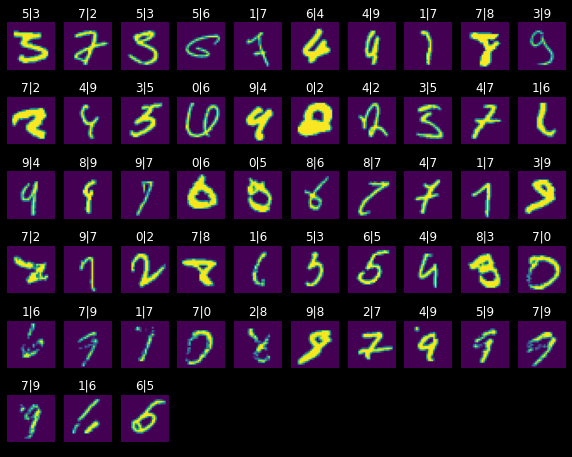

In [11]:
pred_label = pred[0].argmax(dim=1) 
wrong_idx = torch.nonzero(pred_label != torch.from_numpy(test_label))
print(f"incorrect classfication: {wrong_idx.shape[0]}")

ctxs = get_grid(min(wrong_idx.shape[0], 60), nrows=6, ncols=10, figsize=(10,8))

for i, ctx in enumerate(ctxs): 
    idx = wrong_idx[i]
    NumpyImage(test_image[idx], f"{pred_label[idx].item()}|{test_label[idx]}").show(ctx=ctx)

# 9. Conclusion <a name="conclusion"></a>
I've shown how easy it is to train the MNIST dataset once you setup the data classes correctly for fastai. MNIST is an old school dataset that is really easy to get near perfect results on without trying too hard. In this case I took a an existing pre-trained resnet18 model and performed some fine tuning. I didn't even do any data augmentation to get good results. It also shows the power of transfer learning and how you can piggyback off other peoples network that they've trained for weeks or even months.